In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from common import get_cfg, prepare_val
import numpy as np
import cv2
import matplotlib.pyplot as plt
from einops import rearrange, repeat

DATASET_DIR = '/media/hcis-s20/SRL/nuscenes/trainval/'
vehicle_idx = [4, 5, 6, 7, 8, 10, 11, 12]
DYNAMIC = [
    'car', 'truck', 'bus',
    'trailer', 'construction_vehicle',
    'pedestrian',
    'motorcycle', 'bicycle',
    # 'emergency',
]
torch.autograd.set_detect_anomaly(True)

In [2]:
version = 'cvt_labels_nuscenes_v3'
cfg1 = get_cfg(DATASET_DIR, version, 'SparseBEVSeg_Det_3') # cvt_nuscenes_multiclass Sparse
device = torch.device('cuda:0') # cuda:5
model_version = '2024_0910_174005'
CHECKPOINT_PATH = None
# CHECKPOINT_PATH = '../logs/cross_view_transformers_test/' + model_version +'/checkpoints/last.ckpt'
model, network, loader, viz, dataset = prepare_val(cfg1, device, CHECKPOINT_PATH, mode='val', batch_size=4)

/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:50: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='../config')
/media/hcis-s20/SRL/cross_view_ae/cross_view_transformers/scripts/common.py:14: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path='./config')


Loaded pretrained weights for efficientnet-b4


/home/hcis-s20/miniconda3/envs/cvt_2/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hcis-s20/miniconda3/envs/cvt_2/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Dataset length: 6019


In [3]:
network.to(device)
model.to(device)
model.metrics.reset()
with_grad = True

if with_grad:
    network.train()
    # with torch.no_grad():
    for i,batch in enumerate(loader):
        print(i,end='\r')
        if i != 0:
            continue
        for k, v in batch.items():
            if isinstance(v, torch.Tensor):
                batch[k] = v.to(device)
            elif isinstance(v, list):
                if isinstance(v[0], torch.Tensor):
                    batch[k] = [i.to(device) for i in v]
            else:
                batch[k] = v
        pred = network(batch)
        loss = model.loss_func(pred,batch)
        loss[0].backward()
        vis_result = viz(batch,pred)
        break
else:
    network.eval()
    with torch.no_grad():
        for i,batch in enumerate(loader):
            print(i,end='\r')
            for k, v in batch.items():
                if isinstance(v, torch.Tensor):
                    batch[k] = v.to(device)
                elif isinstance(v, list):
                    if isinstance(v[0], torch.Tensor):
                        batch[k] = [i.to(device) for i in v]
                else:
                    batch[k] = v
            pred = network(batch)
            model.metrics.update(pred,batch)
            # pred['mid_output']['sampled_feats'].retain_grad()
            # loss = model.loss_func(pred,batch)
            # loss[0].backward()
            # vis_result = viz(batch,pred)
            # if i == 25:
            break   
        
if CHECKPOINT_PATH is None:
    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is None:
            print(name)
# model.metrics.update(pred,batch)


/home/hcis-s20/miniconda3/envs/cvt_2/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


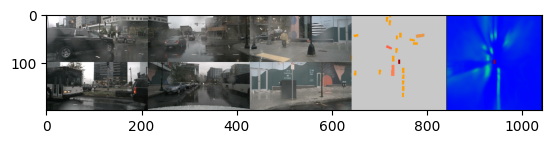

In [ ]:
batch = dataset.__getitem__(4004)
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v.to(device)[None]
    elif isinstance(v, list):
        if isinstance(v[0], torch.Tensor):
            batch[k] = [i.to(device) for i in v]
    else:
        batch[k] = v
with torch.no_grad():
    pred = network(batch)
# pred = None
vis_result = viz(batch, pred)
plt.imshow(vis_result[0])

In [ ]:
# attention = pred['mid_output']['attention']
# attention = rearrange(attention, '(b h w) m 1 p -> b h w m p', b=4, h=200, w=200)
stage = 1
h = w = 50 if stage == 0 else 200
points = rearrange(pred['mid_output'][f"stage_{stage}"]['sample_points_cam'], 'b (h w) p d -> b h w p d',h=h, w=w)
pos_3d = rearrange(pred['mid_output'][f"stage_{stage}"]['pos_3d'], 'b (h w) 1 p d -> b h w p d',h=h, w=w)
reference_points = rearrange(pred['mid_output'][f"stage_{stage}"]['reference_points'], 'b (h w) 1 p d -> b h w p d',h=h, w=w)
weight = rearrange(pred['mid_output'][f"stage_{stage}"]['weight'], 'b (h w) 1 p d -> b h w p d',h=h, w=w)

Text(0.5, 1.0, 'Prediction')

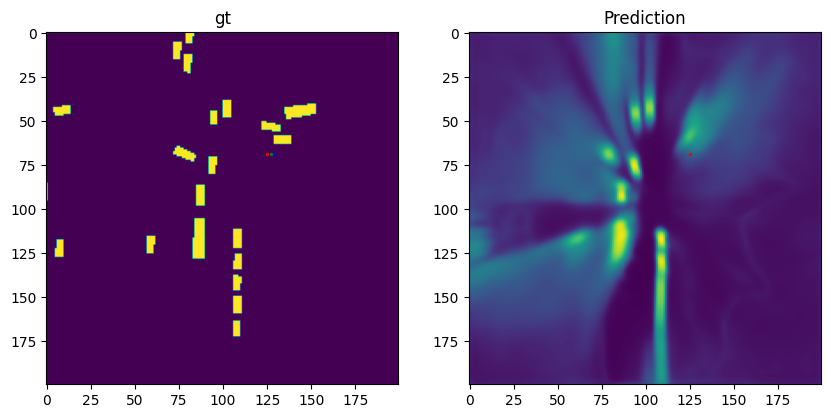

In [ ]:
batch_index = 0
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
y = 69
x = 125
vehicle_idx = [[4,5,6,7,8,10,11,12]]
vehicles = [batch['bev'][:, idx].max(1, keepdim=True).values for idx in vehicle_idx]
vehicles = torch.cat(vehicles, 1)
ax1.imshow(vehicles[batch_index,0].detach().cpu().numpy())
ax1.scatter([x],[y], s=2, c='r')
ax1.scatter([x+2],[y], s=2, c='g')
ax1.scatter([x+4],[y], s=2, c='b')
ax1.set_title('gt')

ax2.imshow(((pred['VEHICLE'][batch_index,0].sigmoid().detach().cpu())).numpy())
ax2.scatter([x],[y], s=2, c='r')
ax2.set_title('Prediction')
# plt.title('2D')

In [ ]:
bev_prediction_index = pred['VEHICLE'][batch_index,0,y,x].sigmoid()
if stage == 0:
    y = y // 4
    x = x // 4

pts_2d = points[batch_index, y, x]
pos_3d_index = pos_3d[batch_index, y, x]
reference_points_index = reference_points[batch_index, y, x]
weight_index = weight[batch_index, y, x]
mask = (pts_2d[:,0] > 0) & (pts_2d[:,0] < 1) & (pts_2d[:,1] > 0) & (pts_2d[:,1] < 1)
pts_2d = pts_2d[mask].cpu().numpy()
pos_3d_index = pos_3d_index[mask].cpu().numpy()
reference_points_index = reference_points_index[mask].cpu().numpy()
weight_index = weight_index[mask].cpu().numpy()

pts_2d[:, 0] *= 480
pts_2d[:, 1] *= 224

BEV Prediction tensor(0.2739)
Sampled points: [ 15.3921 -12.7371  -0.2092],	 pos 2d: [ 28.0539 -23.6271  -1.2492], 	weight: [0.]
Sampled points: [ 1.54837e+01 -1.27046e+01 -5.70000e-03],	 pos 2d: [ 30.3641 -25.422   -1.2053], 	weight: [0.]
Sampled points: [ 15.4493 -12.571    0.1397],	 pos 2d: [ 25.8611 -21.35    -0.5796], 	weight: [0.]
Sampled points: [ 15.1767 -12.5747   0.4873],	 pos 2d: [ 19.3478 -16.088    0.3885], 	weight: [0.051]
Sampled points: [ 15.3701 -12.8446   0.45  ],	 pos 2d: [ 19.9915 -16.768    0.3235], 	weight: [0.0253]
Sampled points: [ 15.4893 -12.8423   0.7785],	 pos 2d: [ 15.2998 -12.5612   0.9749], 	weight: [0.9848]
Sampled points: [ 15.2833 -12.5685   1.1152],	 pos 2d: [ 15.4016 -12.5682   1.2822], 	weight: [0.9958]
Sampled points: [ 15.4129 -12.5792   1.4732],	 pos 2d: [ 19.5924 -16.0241   1.6746], 	weight: [0.053]


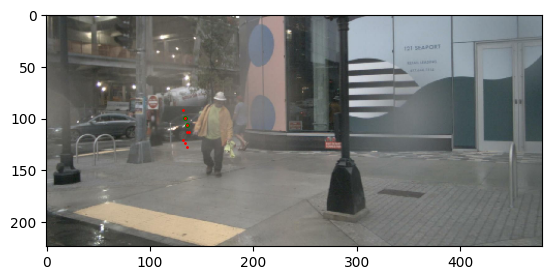

In [ ]:
cam_index = 2
print("BEV Prediction", bev_prediction_index)
plt.imshow(batch['image'][0,cam_index].cpu().permute(1,2,0))
for i in range(len(pts_2d)):
    print(f"Sampled points: {np.round(reference_points_index[i], 4)},\t pos 2d: {np.round(pos_3d_index[i], 4)}, \tweight: {np.round(weight_index[i], 4)}")
    # print(f"Sampled points: {np.round(reference_points_index[i], 4)}")
    # print(att_[head_index,i])

    plt.scatter(pts_2d[i,0], pts_2d[i,1], s=6, c='g', alpha=max(0.0, np.round(weight_index[i], 4)))
    plt.scatter(pts_2d[i,0], pts_2d[i,1], s=1, c='r')
    # plt.scatter(pts_2d[i,0], pts_2d[i,1], alpha=max(float(att_[head_index,i]), 0.1), s=4, c='r')

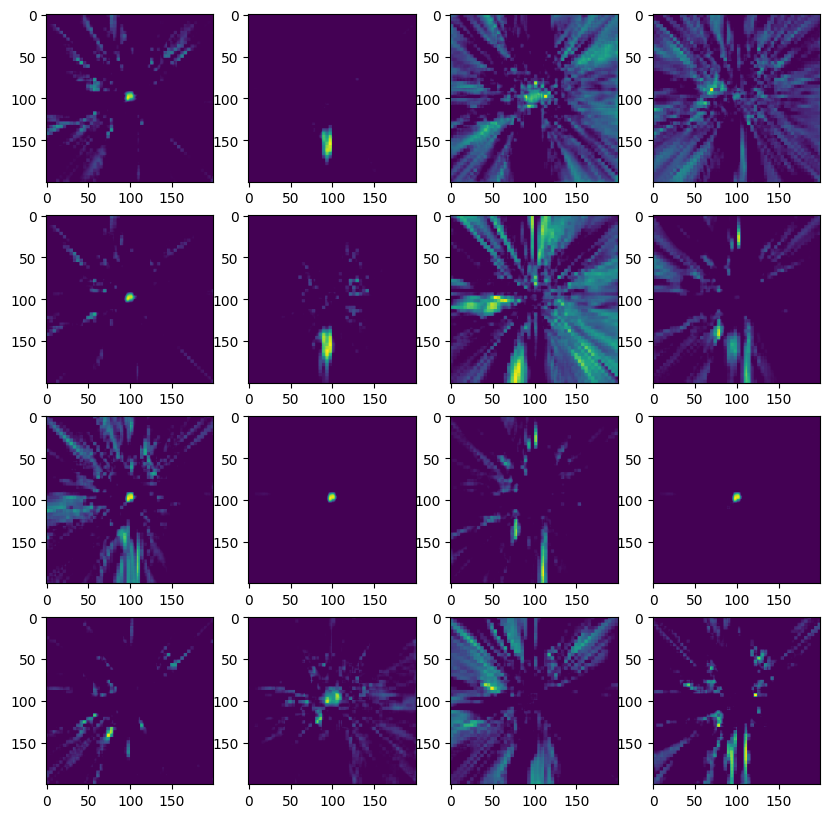

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=128)
feat = pred['mid_output']['inter_output'][0][0].permute(1,2,0).view(-1, 128).cpu().numpy()
# feat = pca.fit_transform(feat).reshape(200,200,128)
feat = feat.reshape(200,200,128)
row, column = 4, 4
fig, ax = plt.subplots(row, column, figsize=(10, 10))
for i in range(row):
    for j in range(column):
        ax[i][j].imshow(feat[:,:,16+ i * row + j])

In [ ]:
depth = pred['mid_output']['pred_depth'][0].permute(1,0,2,3).view(3, -1).cpu().numpy()
print(depth.shape)
plt.scatter(depth[0,:], depth[1,:])

In [ ]:
import plotly.graph_objs as go
import plotly.io as pio

# Create a 3D scatter plot
scatter = go.Scatter3d(
    x=depth[0],
    y=depth[1],
    z=depth[2],
    mode='markers',
    marker=dict(
        size=5,
        color=pred['mid_output']['pred_depth'][0,3,2],            # Color by the z-value
        colorscale='Viridis',
        opacity=0.1
    )
)

# Set up the layout
layout = go.Layout(
    scene=dict(
        xaxis_title='X Axis',
        yaxis_title='Y Axis',
        zaxis_title='Z Axis'
    ),
    margin=dict(l=0, r=0, b=0, t=0) # Remove margins
)

# Combine the plot and layout
fig = go.Figure(data=[scatter], layout=layout)

# Show the plot
pio.show(fig)


In [ ]:
from nuscenes.nuscenes import NuScenes

# Load the nuScenes dataset (mini-split, in this case).
nusc = NuScenes(version='v1.0-trainval', dataroot='/media/hcis-s20/SRL/nuscenes/trainval/', verbose=False)

In [ ]:
from nuscenes.utils.data_classes import LidarPointCloud
import os
from pyquaternion import Quaternion

sample_rec = nusc.get('sample', batch['token'][3])
min_distance = 1.0

sample_data_token = sample_rec['data']['LIDAR_TOP']
current_sd_rec = nusc.get('sample_data', sample_data_token)
# Load up the pointcloud and remove points close to the sensor.
current_pc = LidarPointCloud.from_file(os.path.join(nusc.dataroot, current_sd_rec['filename']))
current_pc.remove_close(min_distance)

# Homogeneous transformation matrix from sensor coordinate frame to ego car frame.
current_cs_rec = nusc.get('calibrated_sensor', current_sd_rec['calibrated_sensor_token'])
current_pc.rotate(Quaternion(current_cs_rec['rotation']).rotation_matrix)
current_pc.translate(np.array(current_cs_rec['translation']))
current_pc.transform

In [ ]:
lidar_points = current_pc.points[:3]
# lidar_points[2, :] = 1
# lidar_points = batch['view'][0].cpu().numpy() @ lidar_points
plt.scatter(lidar_points[1], lidar_points[0], s=0.25)
plt.xlim(-50, 50)
plt.ylim(-50, 50)

In [ ]:
batch['view'][0]

In [ ]:
nusc.render_sample(batch['token'][0])

In [ ]:
batch = dataset.__getitem__(4004)
for k, v in batch.items():
    if isinstance(v, torch.Tensor):
        batch[k] = v[None]
# with torch.no_grad():
#     pred = network(batch)
pred = None
vis_result = viz(batch, pred)
plt.imshow(vis_result[0])

In [ ]:
plt.imshow(pred['VEHICLE'][0,0].sigmoid())

In [ ]:
import torch.nn as nn
import torch
x = torch.rand((4,20,20,128))
x = torch.split(x, 64, -1)
print(x[0].shape, x[1].shape)

In [ ]:
import torch
torch.linspace(-0.5, 1.5, 8).sigmoid() * 8 - 4

In [ ]:
import torch
dbound = [4.0, 45.0, 1.0]
torch.arange(*dbound, dtype=torch.float).view(-1, 1, 1).expand(-1, 14, 30).shape

In [ ]:
import torch
tensor1 = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
tensor2 = torch.tensor([[1.1, 2.1, 3.1], [10.0, 10.0, 10.0]])

# 1. Compute the difference between the two tensors
difference = tensor1 - tensor2

# 2. Compute the norm (Euclidean norm) along the last dimension
norm = torch.norm(difference, dim=1)

# 3. Apply a thresholding function
# Here, we use a Gaussian-like function: exp(-alpha * norm^2)
alpha = 0.075  # You can tune this parameter
output = torch.exp(-alpha * norm**2)
print(norm)
print(output)
offset = 8

alpha = 0.05
x = torch.linspace(-offset, offset, 100, dtype=torch.float32)
y = torch.exp(-alpha * x ** 2)
plt.plot(x.numpy(), y.numpy(), label=str(alpha))

alpha = 0.075
x = torch.linspace(-offset, offset, 100, dtype=torch.float32)
y = torch.exp(-alpha * x ** 2)
plt.plot(x.numpy(), y.numpy(), label=str(alpha))

alpha = 0.1
x = torch.linspace(-offset, offset, 100, dtype=torch.float32)
y = torch.exp(-alpha * x ** 2)
plt.plot(x.numpy(), y.numpy(), label=str(alpha))

alpha = 0.15
x = torch.linspace(-offset, offset, 100, dtype=torch.float32)
y = torch.exp(-alpha * x ** 2)
plt.plot(x.numpy(), y.numpy(), label=str(alpha))
plt.plot(x, [0.1] * 100)
plt.legend()

In [ ]:
ds = torch.arange(4.0, 45.0, 1.0, dtype=torch.float)
print(ds)

In [ ]:
index  = torch.arange(start=0, end=64, step=1).float()
index_1 = index + 1
bin_size = (60) / (64 * (1 + 64))
coords_d = 1 + bin_size * index * index_1
print(coords_d)

In [ ]:
index  = torch.arange(start=0, end=120, step=1).float()
bin_size = (60) / (120)
coords_d = 1 + bin_size * index
print(coords_d)

In [ ]:
import torch
import torch.nn as nn
x = torch.randn(1, 3, 5, 5)
layer = nn.LayerNorm([3, 5, 5])
print(x)
print(layer(x))

In [ ]:
b = 2
h = 5
w = 5
height = torch.linspace(0, 1.0, 8)
height = height.view(1,1,1,-1).expand(b, h, w, -1)
print(height.shape)

torch.Size([2, 5, 5, 8])


In [ ]:
import torch
a = torch.rand((9))
print(a)
print(torch.where(a < 0.5, torch.tensor(0.0, device=a.device), torch.tensor(1.0, device=a.device)))

tensor([0.3015, 0.0679, 0.1494, 0.7322, 0.4012, 0.1382, 0.4780, 0.6993, 0.7932])
tensor([0., 0., 0., 1., 0., 0., 0., 1., 1.])
